<a href="https://colab.research.google.com/github/RohanCoderiiitb/Neuromorphic-Circuits-Adaptive-Neuron/blob/main/Adaptive_Neuron_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

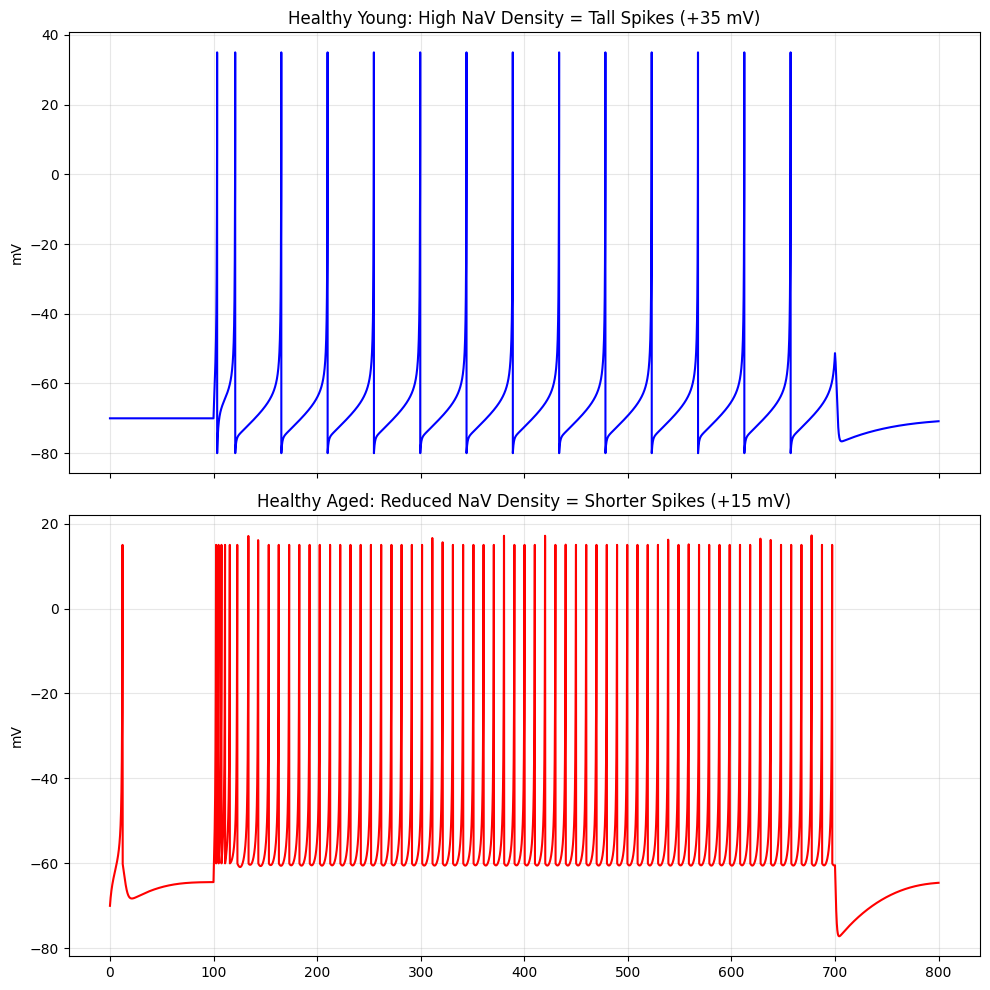

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def simulate_accurate_trace(label, params):
    dt = 0.05
    t = np.arange(0, 800, dt)
    steps = len(t)

    v = -70 * np.ones(steps)
    u = params['b'] * v

    I = np.zeros(steps)
    I[int(100/dt):int(700/dt)] = 10

    for i in range(1, steps):
        v_prev = v[i-1]
        u_prev = u[i-1]

        dv = 0.04*v_prev**2 + 5*v_prev + 140 - u_prev + I[i]
        du = params['a']*(params['b']*v_prev - u_prev)

        v[i] = v_prev + dv*dt
        u[i] = u_prev + du*dt

        if v[i] >= 30:
            v[i-1] = params['peak_amp']

            v[i] = params['c']
            u[i] += params['d']

    return t, v

young_params = {'a': 0.02, 'b': 0.2, 'c': -80, 'd': 8, 'peak_amp': 35}

aged_params  = {'a': 0.03, 'b': 0.25,'c': -60, 'd': 2, 'peak_amp': 15}

t, v_young = simulate_accurate_trace("Young", young_params)
t, v_aged = simulate_accurate_trace("Aged", aged_params)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axes[0].plot(t, v_young, 'b')
axes[0].set_title("Healthy Young: High NaV Density = Tall Spikes (+35 mV)")
axes[0].set_ylabel("mV")
axes[0].grid(alpha=0.3)

axes[1].plot(t, v_aged, 'r')
axes[1].set_title("Healthy Aged: Reduced NaV Density = Shorter Spikes (+15 mV)")
axes[1].set_ylabel("mV")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import find_peaks

def get_biophysical_metrics(t, v, stim_start=50, stim_end=450):
    dt = t[1] - t[0]

    peaks, _ = find_peaks(v, height=0, distance=int(2/dt))
    spike_times = t[peaks]

    valid_spikes = spike_times[(spike_times >= stim_start) & (spike_times <= stim_end)]

    if len(valid_spikes) > 1:
        isis = np.diff(valid_spikes)
        adapt_index = isis[-1] / isis[0]
    else:
        adapt_index = 0.0

    post_stim_idx_start = int(stim_end / dt)
    post_stim_idx_end = int((stim_end + 100) / dt)

    if post_stim_idx_end < len(v):
        window = v[post_stim_idx_start : post_stim_idx_end]
        min_v = np.min(window)
        ahp_depth = -70 - min_v

        if ahp_depth < 0: ahp_depth = 0
    else:
        ahp_depth = 0

    return adapt_index, ahp_depth

ai_young, ahp_young = get_biophysical_metrics(t, v_young)
ai_aged, ahp_aged = get_biophysical_metrics(t, v_aged)

print(f"{'METRIC':<25} | {'YOUNG NEURON':<15} | {'AGED NEURON':<15}")
print("-" * 60)
print(f"{'Adaptation Index':<25} | {ai_young:>15.2f} | {ai_aged:>15.2f}")
print(f"{'AHP Depth (mV)':<25} | {ahp_young:>15.2f} | {ahp_aged:>15.2f}")
print("-" * 60)
print(f"{'Physiological Meaning':<25} | {'Dynamic Braking':<15} | {'Rigid/Static':<15}")

METRIC                    | YOUNG NEURON    | AGED NEURON    
------------------------------------------------------------
Adaptation Index          |            2.56 |            4.10
AHP Depth (mV)            |            8.91 |            7.73
------------------------------------------------------------
Physiological Meaning     | Dynamic Braking | Rigid/Static   


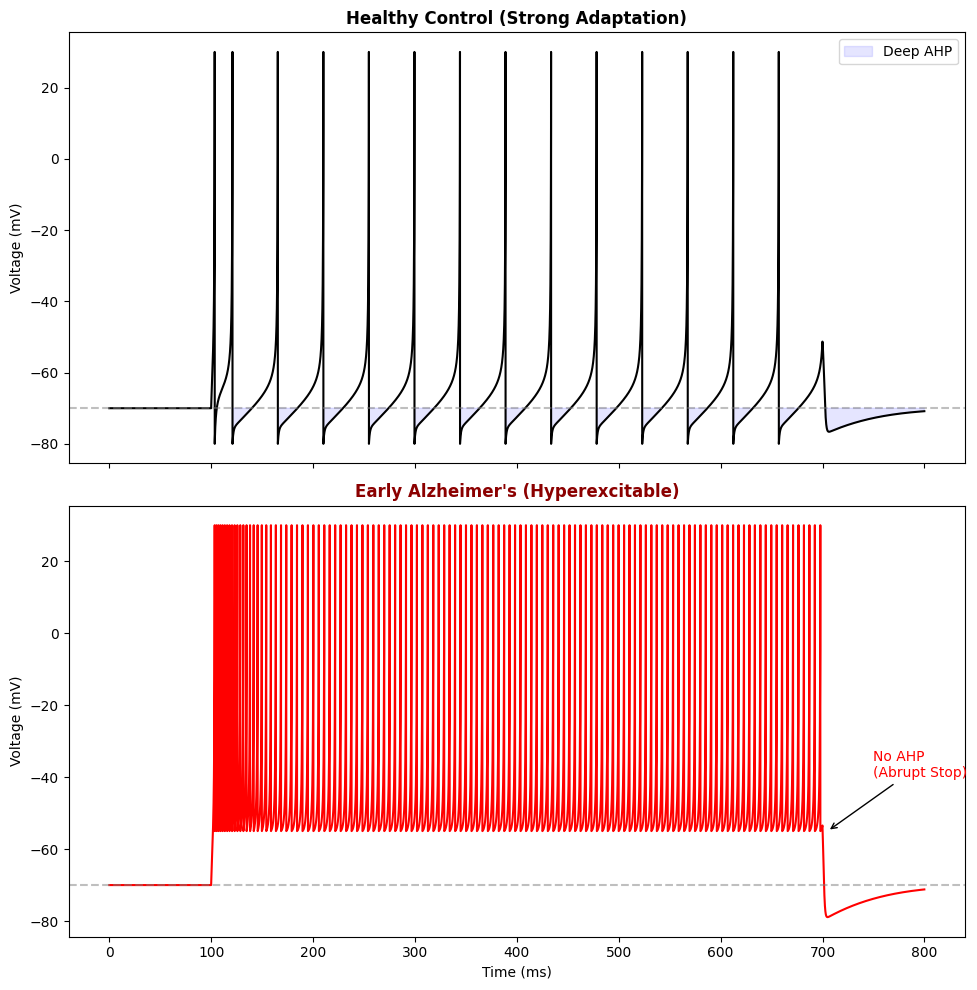

METRIC                         | HEALTHY CONTROL    | ALZHEIMER'S (AD)  
----------------------------------------------------------------------
Adaptation Index (Last/First)  |               2.56 |               1.43
AHP Depth (mV below rest)      |                6.6 |                8.9
----------------------------------------------------------------------
Biophysical Meaning            | Dynamic Control    | Runaway Excitation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ==========================================
# 1. SIMULATION ENGINE
# ==========================================
def simulate_trace(label, params):
    dt = 0.05
    t = np.arange(0, 800, dt)
    steps = len(t)

    v = -70 * np.ones(steps)
    u = params['b'] * v

    # Stimulus: 100ms to 700ms
    I = np.zeros(steps)
    start_idx = int(100/dt)
    end_idx = int(700/dt)
    I[start_idx:end_idx] = 10

    for i in range(1, steps):
        v_prev = v[i-1]
        u_prev = u[i-1]

        dv = 0.04*v_prev**2 + 5*v_prev + 140 - u_prev + I[i]
        du = params['a']*(params['b']*v_prev - u_prev)

        v[i] = v_prev + dv*dt
        u[i] = u_prev + du*dt

        if v[i] >= 30:
            v[i] = params['c']
            u[i] += params['d']
            v[i-1] = 30

    return t, v, 100, 700

# ==========================================
# 2. METRIC EXTRACTION
# ==========================================
def get_metrics(t, v, start_ms, end_ms):
    dt = t[1] - t[0]

    # Find Spikes
    peaks, _ = find_peaks(v, height=0, distance=int(2/dt))
    spike_times = t[peaks]
    valid_spikes = spike_times[(spike_times >= start_ms) & (spike_times <= end_ms)]

    # 1. Adaptation Index
    if len(valid_spikes) > 1:
        isis = np.diff(valid_spikes)
        adapt_index = isis[-1] / isis[0] # Last ISI / First ISI
    else:
        adapt_index = 0.0

    # 2. AHP Depth
    stim_end_idx = int(end_ms / dt)
    # Check 100ms window after stimulus
    post_stim_window = v[stim_end_idx : stim_end_idx + int(100/dt)]
    if len(post_stim_window) > 0:
        min_v = np.min(post_stim_window)
        ahp_depth = -70 - min_v # Relative to resting (-70)
        if ahp_depth < 0: ahp_depth = 0
    else:
        ahp_depth = 0

    return adapt_index, ahp_depth

# ==========================================
# 3. RUN & GENERATE TABLE
# ==========================================

# Define Parameters
healthy_params = {'a': 0.02, 'b': 0.2, 'c': -80, 'd': 8}
alzheimers_params = {'a': 0.02, 'b': 0.2, 'c': -55, 'd': 0.5}

# Run Simulations
t_h, v_h, s_h, e_h = simulate_trace("Healthy", healthy_params)
t_ad, v_ad, s_ad, e_ad = simulate_trace("Alzheimer's", alzheimers_params)

# Calculate Metrics
ai_healthy, ahp_healthy = get_metrics(t_h, v_h, s_h, e_h)
ai_ad, ahp_ad = get_metrics(t_ad, v_ad, s_ad, e_ad)

# --- PLOTTING ---
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot Healthy
axes[0].plot(t_h, v_h, 'k', lw=1.5)
axes[0].set_title(f"Healthy Control (Strong Adaptation)", fontweight='bold')
axes[0].set_ylabel("Voltage (mV)")
axes[0].axhline(-70, color='gray', linestyle='--', alpha=0.5)
axes[0].fill_between(t_h, v_h, -70, where=(v_h < -70), color='blue', alpha=0.1, label="Deep AHP")
axes[0].legend(loc='upper right')

# Plot Alzheimer's
axes[1].plot(t_ad, v_ad, 'r', lw=1.5)
axes[1].set_title(f"Early Alzheimer's (Hyperexcitable)", fontweight='bold', color='darkred')
axes[1].set_ylabel("Voltage (mV)")
axes[1].set_xlabel("Time (ms)")
axes[1].axhline(-70, color='gray', linestyle='--', alpha=0.5)

# Annotations
axes[1].annotate('No AHP\n(Abrupt Stop)', xy=(705, -55), xytext=(750, -40),
                 arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

plt.tight_layout()
plt.show()

print(f"{'METRIC':<30} | {'HEALTHY CONTROL':<18} | {'ALZHEIMER\'S (AD)':<18}")
print("-" * 70)
print(f"{'Adaptation Index (Last/First)':<30} | {ai_healthy:>18.2f} | {ai_ad:>18.2f}")
print(f"{'AHP Depth (mV below rest)':<30} | {ahp_healthy:>18.1f} | {ahp_ad:>18.1f}")
print("-" * 70)
print(f"{'Biophysical Meaning':<30} | {'Dynamic Control':<18} | {'Runaway Excitation':<18}")

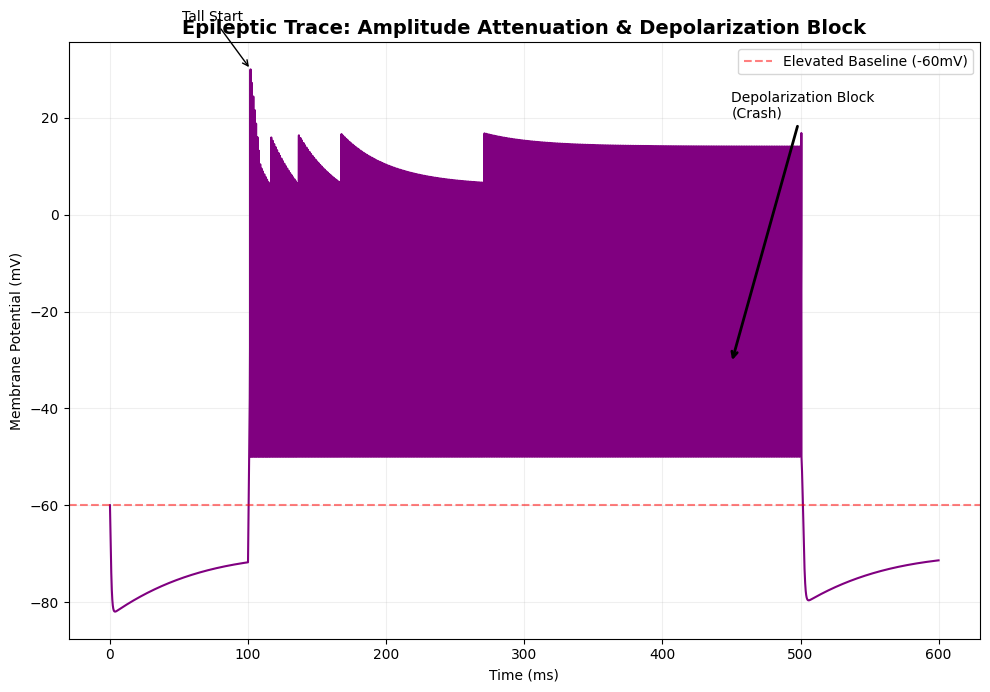

METRIC                              | VALUE           | MEANING
--------------------------------------------------------------------------------
Initial Burst Rate                  | 1000.0          | Extreme Hyperexcitability
First Spike Peak                    | 30.0            | Sodium Channels Fresh
Last Spike Peak                     | 13.9            | Sodium Channels Exhausted
Depolarization Block Level          | -30.6           | Stuck in Inactivated State
--------------------------------------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ==========================================
# 1. SIMULATION ENGINE
# ==========================================
def simulate_epilepsy_attenuation():
    dt = 0.05
    t = np.arange(0, 600, dt)
    steps = len(t)

    # Epilepsy Parameters
    v = -60 * np.ones(steps) # Elevated baseline
    u = 0 * v

    # Sodium Dynamics
    na_available = 1.0
    na_recovery_rate = 0.002
    na_depletion_per_spike = 0.08

    # Stimulus (Massive drive)
    I = np.zeros(steps)
    stim_start = int(100/dt)
    stim_end = int(500/dt)
    I[stim_start:stim_end] = 25

    spikes = []

    for i in range(1, steps):
        v_prev, u_prev = v[i-1], u[i-1]

        dv = 0.04*v_prev**2 + 5*v_prev + 140 - u_prev + I[i]
        du = 0.02*(0.2*v_prev - u_prev)

        v[i] = v_prev + dv*dt
        u[i] = u_prev + du*dt

        # Sodium Recovery
        if na_available < 1.0:
            na_available += na_recovery_rate

        # Spike Event
        if v[i] >= 30:
            actual_peak = -40 + (70 * na_available)

            v[i-1] = actual_peak
            v[i] = -50
            u[i] += 0.05

            na_available -= na_depletion_per_spike
            if na_available < 0: na_available = 0

            # Only count as a valid spike if it's distinct enough
            if actual_peak > -20:
                spikes.append(t[i])

    return t, v, spikes, stim_start, stim_end

# ==========================================
# 2. METRIC EXTRACTION
# ==========================================
def extract_epilepsy_metrics(t, v, spikes, stim_start_idx, stim_end_idx):
    dt = t[1] - t[0]
    stim_start_ms = t[stim_start_idx]

    metrics = {}

    # A. Initial Firing Rate (Burst Intensity)
    # Calculate rate based on the first 5 ISIs to see the initial explosion
    if len(spikes) > 5:
        initial_isis = np.diff(spikes[:6])
        mean_initial_isi = np.mean(initial_isis)
        metrics['initial_rate_hz'] = 1000 / mean_initial_isi
    else:
        metrics['initial_rate_hz'] = 0

    # B. Spike Attenuation (First vs Last Spike Height)
    # We need to find the voltage at the exact spike times
    first_spike_idx = int(spikes[0]/dt)
    last_spike_idx = int(spikes[-1]/dt)

    # Search locally for the peak just in case timing is slightly off
    metrics['first_spike_mv'] = np.max(v[first_spike_idx-5:first_spike_idx+5])
    metrics['last_spike_mv'] = np.max(v[last_spike_idx-5:last_spike_idx+5])

    # C. Depolarization Block Level
    # Check the average voltage in the last 50ms of stimulation
    block_window = v[stim_end_idx - int(50/dt) : stim_end_idx]
    metrics['block_level_mv'] = np.mean(block_window)

    return metrics

# ==========================================
# 3. EXECUTION & PLOTTING
# ==========================================

t, v, spikes, s_start, s_end = simulate_epilepsy_attenuation()
m = extract_epilepsy_metrics(t, v, spikes, s_start, s_end)

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t, v, color='purple', lw=1.5)

# Annotations
ax.set_title("Epileptic Trace: Amplitude Attenuation & Depolarization Block", fontsize=14, fontweight='bold')
ax.set_ylabel("Membrane Potential (mV)")
ax.set_xlabel("Time (ms)")
ax.axhline(-60, color='red', linestyle='--', alpha=0.5, label='Elevated Baseline (-60mV)')

ax.annotate('Tall Start', xy=(spikes[0], m['first_spike_mv']), xytext=(spikes[0]-50, 40),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Depolarization Block\n(Crash)', xy=(450, m['block_level_mv']), xytext=(450, 20),
             arrowprops=dict(facecolor='purple', arrowstyle='->', lw=2))

ax.grid(alpha=0.2)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ==========================================
# 4. METRICS TABLE
# ==========================================
print(f"{'METRIC':<35} | {'VALUE':<15} | {'MEANING'}")
print("-" * 80)
print(f"{'Initial Burst Rate':<35} | {m['initial_rate_hz']:<15.1f} | {'Extreme Hyperexcitability'}")
print(f"{'First Spike Peak':<35} | {m['first_spike_mv']:<15.1f} | {'Sodium Channels Fresh'}")
print(f"{'Last Spike Peak':<35} | {m['last_spike_mv']:<15.1f} | {'Sodium Channels Exhausted'}")
print(f"{'Depolarization Block Level':<35} | {m['block_level_mv']:<15.1f} | {'Stuck in Inactivated State'}")
print("-" * 80)

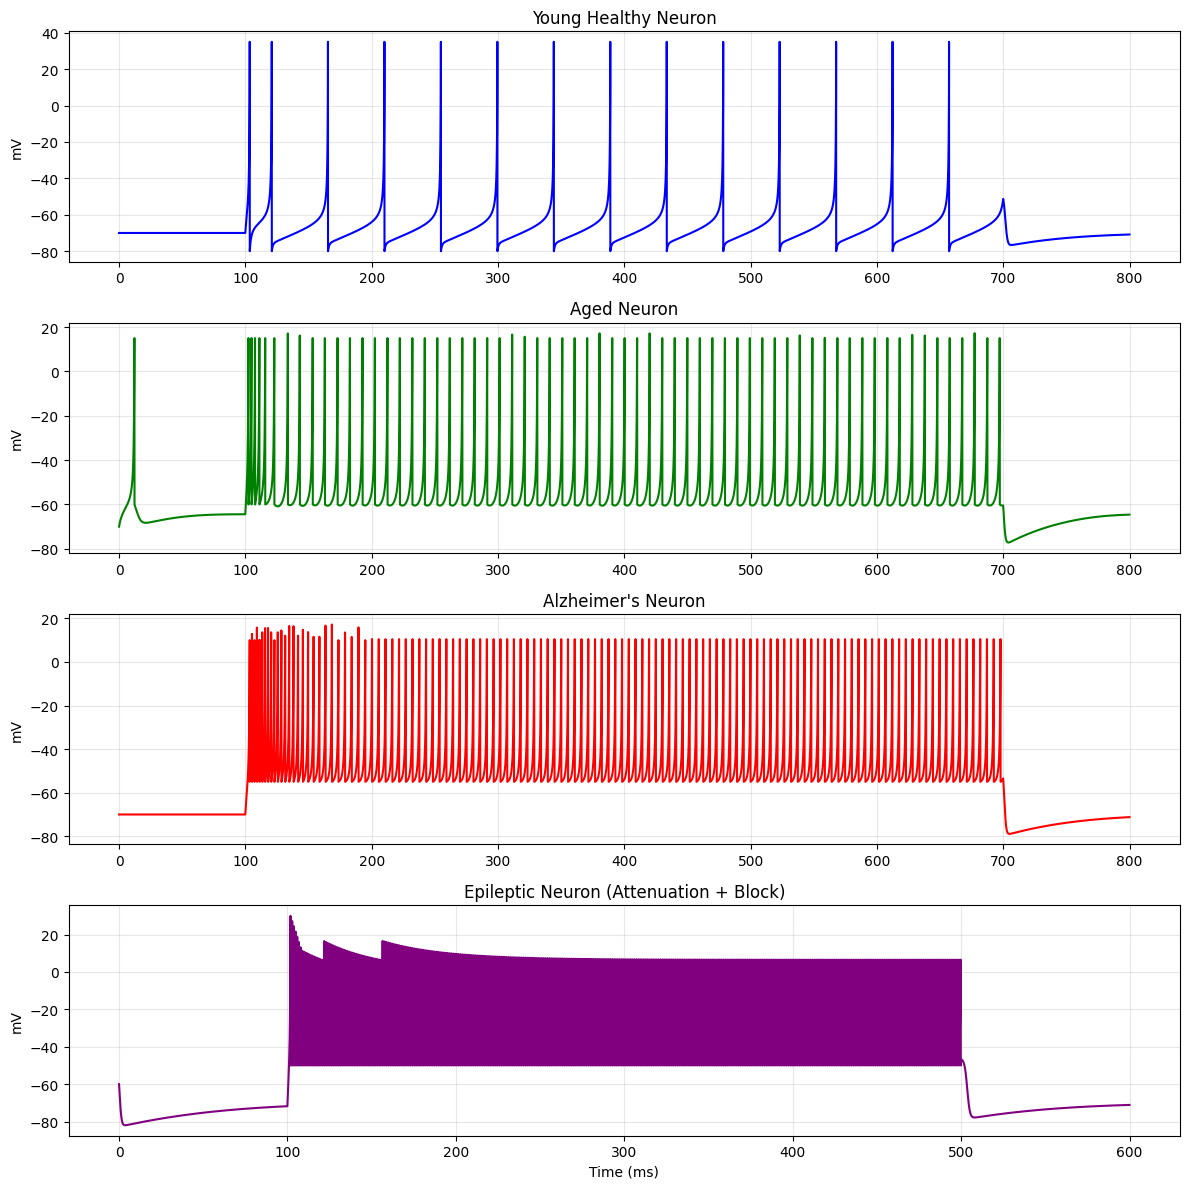


MODEL           | FIRING RATE (Hz)
Young           |    23.33
Aged            |   106.67
Alzheimer       |   198.33
Epilepsy        |   455.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ======================================================
# 1. GENERIC IZHIKEVICH TRACE (Young, Aged, Alzheimer's)
# ======================================================

def simulate_trace(params):
    dt = 0.05
    t = np.arange(0, 800, dt)
    steps = len(t)

    v = -70 * np.ones(steps)
    u = params['b'] * v

    I = np.zeros(steps)
    I[int(100/dt):int(700/dt)] = 10

    for i in range(1, steps):
        v_prev = v[i-1]
        u_prev = u[i-1]

        dv = 0.04 * v_prev**2 + 5*v_prev + 140 - u_prev + I[i]
        du = params['a']*(params['b']*v_prev - u_prev)

        v[i] = v_prev + dv*dt
        u[i] = u_prev + du*dt

        if v[i] >= 30:
            v[i-1] = params.get('peak_amp', 30)
            v[i] = params['c']
            u[i] += params['d']

    return t, v


# ======================================================
# 2. ALZHEIMER / AGED PARAMETERS
# ======================================================

young_params  = {'a':0.02,'b':0.2,'c':-80,'d':8,'peak_amp':35}
aged_params   = {'a':0.03,'b':0.25,'c':-60,'d':2,'peak_amp':15}
alz_params    = {'a':0.02,'b':0.2,'c':-55,'d':0.5,'peak_amp':10}


# ======================================================
# 3. EPILEPSY MODEL (exact same as your code)
# ======================================================

def simulate_epilepsy():
    dt = 0.05
    t = np.arange(0, 600, dt)
    steps = len(t)

    v = -60 * np.ones(steps)
    u = 0 * v

    na_available = 1.0
    na_recovery_rate = 0.002
    na_depletion = 0.08

    I = np.zeros(steps)
    start = int(100/dt)
    end = int(500/dt)
    I[start:end] = 25

    for i in range(1, steps):
        dv = 0.04*v[i-1]**2 + 5*v[i-1] + 140 - u[i-1] + I[i]
        du = 0.02*(0.2*v[i-1] - u[i-1])

        v[i] = v[i-1] + dv*dt
        u[i] = u[i-1] + du*dt

        na_available = min(1.0, na_available + na_recovery_rate)

        if v[i] >= 30:
            peak = -40 + (70 * na_available)
            v[i-1] = peak
            v[i] = -50
            na_available = max(0, na_available - na_depletion)

    return t, v


# ======================================================
# 4. RUN SIMULATIONS
# ======================================================

t_y,  v_y  = simulate_trace(young_params)
t_ag, v_ag = simulate_trace(aged_params)
t_ad, v_ad = simulate_trace(alz_params)
t_ep, v_ep = simulate_epilepsy()


# ======================================================
# 5. 4-PANEL SUBPLOT COMPARISON
# ======================================================

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=False)

axes[0].plot(t_y, v_y, color='blue')
axes[0].set_title("Young Healthy Neuron")
axes[0].set_ylabel("mV")
axes[0].grid(alpha=0.3)

axes[1].plot(t_ag, v_ag, color='green')
axes[1].set_title("Aged Neuron")
axes[1].set_ylabel("mV")
axes[1].grid(alpha=0.3)

axes[2].plot(t_ad, v_ad, color='red')
axes[2].set_title("Alzheimer's Neuron")
axes[2].set_ylabel("mV")
axes[2].grid(alpha=0.3)

axes[3].plot(t_ep, v_ep, color='purple')
axes[3].set_title("Epileptic Neuron (Attenuation + Block)")
axes[3].set_xlabel("Time (ms)")
axes[3].set_ylabel("mV")
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# ======================================================
# UNIVERSAL METRIC: FIRING RATE (Hz)
# ======================================================

def firing_rate(t, v, stim_start=100, stim_end=700):
    dt = t[1] - t[0]

    # Detect spikes
    peaks, _ = find_peaks(v, height=0, distance=int(2/dt))
    spike_times = t[peaks]

    # Count spikes within stimulus
    valid_spikes = spike_times[(spike_times >= stim_start) & (spike_times <= stim_end)]
    spike_count = len(valid_spikes)

    # Convert to Hz
    duration_sec = (stim_end - stim_start) / 1000
    rate_hz = spike_count / duration_sec

    return rate_hz


# Compute firing rates for all models
fr_y  = firing_rate(t_y,  v_y)
fr_ag = firing_rate(t_ag, v_ag)
fr_ad = firing_rate(t_ad, v_ad)
fr_ep = firing_rate(t_ep, v_ep, stim_start=100, stim_end=500)  # epilepsy stim uses 100-500ms


# ======================================================
# 4-MODEL FIRING-RATE COMPARISON TABLE
# ======================================================

print("\n===============================================")
print("MODEL           | FIRING RATE (Hz)")
print("===============================================")
print(f"Young           | {fr_y:8.2f}")
print(f"Aged            | {fr_ag:8.2f}")
print(f"Alzheimer       | {fr_ad:8.2f}")
print(f"Epilepsy        | {fr_ep:8.2f}")
print("===============================================")
